# 09 - DS Diagnostics Modèle, Explicabilité, Robustesse et Storytelling

Objectif: comprendre **pourquoi** le modèle marche (ou échoue), pas seulement mesurer un score.


**Convention de commentaire dans ce notebook (à respecter dans l'analyse)**

- `Constat` : ce que montrent les chiffres/graphes
- `Interprétation` : ce que cela signifie (avec prudence)
- `Décision` : impact pratique sur preprocessing / CV / modèle
- Terminer chaque bloc par une phrase `Impact modèle attendu`


In [5]:
import sys
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from src.v2_pipeline import ensure_dir
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import v2_pipeline as v2
from src.ds_analysis_utils import *

DATA_DIR = ROOT / "data"
ARTIFACT_DS = ensure_dir(ROOT / DEFAULT_DS_DIR)
ARTIFACT_V2 = ROOT / v2.DEFAULT_V2_DIR

SEED = 42
QUICK_ANALYSIS = True
FULL_ANALYSIS = False
SAMPLE_N = 3000
np.random.seed(SEED)


In [6]:
print("ARTIFACT_V2 exists:", ARTIFACT_V2.exists())
if ARTIFACT_V2.exists():
    for p in sorted(ARTIFACT_V2.iterdir()):
        if p.is_file():
            print(f"{p.name:<40} {p.stat().st_size/1024:.1f} KB")


ARTIFACT_V2 exists: True
dataset_meta_v2.json                     0.5 KB
ensemble_weights_v2.json                 1.5 KB
feature_set_comparison_v2.csv            4.9 KB
folds_aux_blocked5.parquet               685.9 KB
folds_primary_time.parquet               464.9 KB
folds_secondary_group.parquet            689.7 KB
model_cards_v2.csv                       4.6 KB
objective_screening_v2.csv               5.6 KB
oof_predictions_selected_v2.parquet      226322.5 KB
oof_predictions_v2.parquet               117020.2 KB
pred_distribution_audit_v2.csv           44.4 KB
run_registry_stage1.csv                  20.4 KB
run_registry_stage2.csv                  272.0 KB
run_registry_v2.csv                      21.3 KB
segment_diagnostics_v2.parquet           10.8 KB
selected_models_v2.csv                   2.9 KB
selection_report_v2.csv                  11.6 KB
shakeup_v2_ensemble.parquet              69.1 KB
shakeup_v2_ensemble_tail.parquet         69.1 KB
shakeup_v2_single.parquet             

In [7]:
# Chargement des artefacts V2 (avec fallback)
paths = {
    "run_registry": ARTIFACT_V2 / "run_registry_v2.csv",
    "oof_predictions": ARTIFACT_V2 / "oof_predictions_v2.parquet",
    "selected_models": ARTIFACT_V2 / "selected_models_v2.csv",
    "selection_report": ARTIFACT_V2 / "selection_report_v2.csv",
    "ensemble_weights": ARTIFACT_V2 / "ensemble_weights_v2.json",
    "submission_audit": ARTIFACT_V2 / "submission_audit_v2.json",
    "pred_distribution_audit": ARTIFACT_V2 / "pred_distribution_audit_v2.csv",
}

run_df = pd.read_csv(paths["run_registry"]) if paths["run_registry"].exists() else pd.DataFrame()
oof_df = pd.read_parquet(paths["oof_predictions"]) if paths["oof_predictions"].exists() else pd.DataFrame()
selected_df = pd.read_csv(paths["selected_models"]) if paths["selected_models"].exists() else pd.DataFrame()
selection_report_df = pd.read_csv(paths["selection_report"]) if paths["selection_report"].exists() else pd.DataFrame()
ens_meta = json.loads(paths["ensemble_weights"].read_text(encoding="utf-8")) if paths["ensemble_weights"].exists() else {}
submission_audit = json.loads(paths["submission_audit"].read_text(encoding="utf-8")) if paths["submission_audit"].exists() else {}
pred_dist_df = pd.read_csv(paths["pred_distribution_audit"]) if paths["pred_distribution_audit"].exists() else pd.DataFrame()

print("run_df:", run_df.shape, "oof_df:", oof_df.shape, "selected_df:", selected_df.shape)
display(run_df.head(3))
display(selected_df.head(3))


run_df: (81, 18) oof_df: (8100000, 18) selected_df: (6, 32)


,level,split,feature_set,engine,family,config_id,seed,severity_mode,calibration,tail_mapper,fold_id,n_valid,rmse_prime,auc_freq,brier_freq,rmse_sev_pos,q99_ratio_pos,run_id
0,run,primary_time,base_v2,catboost,two_part_classic,cb_v2_c1,42,classic,none,isotonic,-1,40000,544.609188,0.612200,0.054695,1464.368583,0.310240,base_v2|catboost|two_part_classic|cb_v2_c1|42|...
1,run,primary_time,base_v2,catboost,two_part_classic,cb_v2_c1,42,classic,isotonic,isotonic,-1,40000,544.092828,0.608750,0.054531,1464.368583,0.310240,base_v2|catboost|two_part_classic|cb_v2_c1|42|...
2,run,secondary_group,base_v2,catboost,two_part_classic,cb_v2_c1,42,classic,none,isotonic,-1,50000,541.957024,0.651965,0.054078,1455.708350,0.320485,base_v2|catboost|two_part_classic|cb_v2_c1|42|...


,run_id,feature_set,engine,family,config_id,seed,severity_mode,calibration,tail_mapper,rmse_aux_blocked5,...,tail_penalty,selection_score,accepted_secondary,accepted_aux,accepted_tail,accepted_collapse,accepted_dispersion,accepted,decision_reason,rank
0,base_v2|catboost|two_part_tweedie|cb_v2_c1|42|...,base_v2,catboost,two_part_tweedie,cb_v2_c1,42,weighted_tail,isotonic,isotonic,542.595859,...,0.671267,545.585711,True,True,True,True,True,True,accepted,1
1,base_v2|catboost|two_part_tweedie|cb_v2_c1|42|...,base_v2,catboost,two_part_tweedie,cb_v2_c1,42,classic,isotonic,isotonic,542.571435,...,0.678882,545.732181,True,True,True,True,True,True,accepted,2
2,base_v2|catboost|two_part_classic|cb_v2_c1|42|...,base_v2,catboost,two_part_classic,cb_v2_c1,42,classic,isotonic,isotonic,542.670668,...,0.689760,545.834739,True,True,True,True,True,True,accepted,3


## Rappel du protocole (à présenter)

- **Split primaire**: `primary_time` (référence de classement local)
- **Split secondaire**: `secondary_group` sur `id_client` (anti-fuite)
- **Split auxiliaire**: `aux_blocked5` (stress test)
- **OOF**: prédictions sur validation uniquement, modèle n'ayant pas vu les lignes
- **Score Kaggle**: RMSE sur la prime prédite (coût réel vs prime)

Définitions utiles:
- `AUC`, `Gini`, `Brier`, `R²`, `RMSE` (rappels à expliquer à l'oral)


In [8]:
# Baselines indispensables (si OOF dispo)
if not oof_df.empty:
    # on prend un split/runs OOF disponible pour obtenir y_true
    d0 = oof_df[(oof_df["is_test"] == 0) & oof_df["y_sev"].notna()].copy()
    if len(d0):
        y_true = d0.groupby("row_idx")["y_sev"].first().sort_index().to_numpy()
        mean_pred = np.full_like(y_true, float(np.mean(y_true)), dtype=float)
        zero_pred = np.zeros_like(y_true, dtype=float)
        pure_const = np.full_like(y_true, float(np.mean(y_true)), dtype=float)
        baseline_df = pd.DataFrame([
            {"baseline": "mean_prime", "rmse": _rmse(y_true, mean_pred)},
            {"baseline": "all_zero", "rmse": _rmse(y_true, zero_pred)},
            {"baseline": "pure_premium_constant", "rmse": _rmse(y_true, pure_const)},
        ])
        display(baseline_df)
    else:
        print("OOF vide -> impossible de recalculer les baselines.")
else:
    print("Artifacts V2 absents -> section baseline en mode descriptif.")


,baseline,rmse
0,mean_prime,545.397425
1,all_zero,555.106812
2,pure_premium_constant,545.397425


In [9]:
# Comparatif moteurs / familles / splits
if not run_df.empty:
    rr = run_df.copy()
    rr = rr[rr["level"] == "run"] if "level" in rr.columns else rr
    cols = [c for c in ["feature_set","engine","family","severity_mode","split","rmse_prime","auc_freq","brier_freq","rmse_sev_pos","q99_ratio_pos","distribution_collapse_flag","tail_dispersion_flag"] if c in rr.columns]
    display(rr[cols].sort_values(["split","rmse_prime"]).head(40))

    summary = rr.pivot_table(
        index=["engine","family","severity_mode"],
        values=[c for c in ["rmse_prime","q99_ratio_pos","distribution_collapse_flag"] if c in rr.columns],
        aggfunc="mean",
    ).sort_values("rmse_prime")
    display(summary.head(20))


,feature_set,engine,family,severity_mode,split,rmse_prime,auc_freq,brier_freq,rmse_sev_pos,q99_ratio_pos
17,base_v2,catboost,two_part_tweedie,classic,aux_blocked5,542.571435,0.635468,0.054255,1461.456772,0.283293
16,base_v2,catboost,two_part_tweedie,classic,aux_blocked5,542.575544,0.638932,0.054260,1461.456772,0.283293
11,base_v2,catboost,two_part_classic,weighted_tail,aux_blocked5,542.577648,0.635468,0.054255,1462.643524,0.297873
10,base_v2,catboost,two_part_classic,weighted_tail,aux_blocked5,542.578502,0.638932,0.054260,1462.643524,0.297873
23,base_v2,catboost,two_part_tweedie,weighted_tail,aux_blocked5,542.595859,0.635468,0.054255,1461.475757,0.298799
22,base_v2,catboost,two_part_tweedie,weighted_tail,aux_blocked5,542.611299,0.638932,0.054260,1461.475757,0.298799
5,base_v2,catboost,two_part_classic,classic,aux_blocked5,542.670668,0.635468,0.054255,1464.672223,0.294504
4,base_v2,catboost,two_part_classic,classic,aux_blocked5,542.681086,0.638932,0.054260,1464.672223,0.294504
77,base_v2,xgboost,two_part_tweedie,weighted_tail,aux_blocked5,542.841891,0.630252,0.054308,1461.418314,0.303062
65,base_v2,xgboost,two_part_classic,weighted_tail,aux_blocked5,542.842109,0.630252,0.054308,1462.489815,0.283711


q99_ratio_pos  rmse_prime
engine   family           severity_mode                           
catboost two_part_tweedie weighted_tail       0.313388  542.968583
         two_part_classic weighted_tail       0.303913  542.994180
         two_part_tweedie classic             0.306377  542.997573
         two_part_classic classic             0.308409  543.015681
xgboost  two_part_classic weighted_tail       0.300106  543.173975
         two_part_tweedie weighted_tail       0.305674  543.184571
                          classic             0.303995  543.185727
         two_part_classic classic             0.319355  543.213443
lightgbm two_part_classic weighted_tail       0.307744  543.405103
catboost direct_tweedie   classic             0.333008  543.442768
lightgbm two_part_classic classic             0.310998  543.445210
         two_part_tweedie classic             0.315481  543.445903
                          weighted_tail       0.291883  543.469590
xgboost  direct_tweedie   classic             0.316589  543.719212
lightgbm direct_tweedie   classic             0.329393  544.076564

In [10]:
# Sélection finale et raisons de rejet / acceptation
if not selection_report_df.empty:
    cols = [c for c in ["run_id","rank","selection_score","accepted","decision_reason","rmse_primary_time","rmse_secondary_group","rmse_aux_blocked5","q99_primary_time","distribution_collapse_flag","tail_dispersion_flag"] if c in selection_report_df.columns]
    display(selection_report_df[cols].head(30))
else:
    print("selection_report_v2.csv absent.")


,run_id,rank,selection_score,accepted,decision_reason,rmse_primary_time,rmse_secondary_group,rmse_aux_blocked5,q99_primary_time,distribution_collapse_flag,tail_dispersion_flag
0,base_v2|catboost|two_part_tweedie|cb_v2_c1|42|...,1,545.585711,True,accepted,543.897946,542.188168,542.595859,0.328733,0.0,0.0
1,base_v2|catboost|two_part_tweedie|cb_v2_c1|42|...,2,545.732181,True,accepted,544.026383,542.170569,542.571435,0.321118,0.0,0.0
2,base_v2|catboost|two_part_classic|cb_v2_c1|42|...,3,545.834739,True,accepted,544.092828,542.083295,542.670668,0.310240,0.0,0.0
3,base_v2|xgboost|two_part_tweedie|xgb_v2_c1|42|...,4,546.014272,True,accepted,544.322745,542.289359,542.888025,0.330594,0.0,0.0
4,base_v2|lightgbm|two_part_classic|lgb_v2_c1|42...,5,546.020444,True,accepted,544.351093,542.725670,543.121771,0.336075,0.0,0.0
5,base_v2|xgboost|two_part_tweedie|xgb_v2_c1|42|...,6,546.021755,True,accepted,544.336071,542.394952,542.883211,0.330594,0.0,0.0
6,base_v2|xgboost|two_part_classic|xgb_v2_c1|42|...,7,546.028749,True,accepted,544.318236,542.482881,542.877905,0.319171,0.0,0.0
7,base_v2|xgboost|two_part_classic|xgb_v2_c1|42|...,8,546.038646,True,accepted,544.315178,542.413056,542.842109,0.314437,0.0,0.0
8,base_v2|xgboost|two_part_classic|xgb_v2_c1|42|...,9,546.040011,True,accepted,544.311147,542.307956,542.854402,0.314437,0.0,0.0
9,base_v2|xgboost|two_part_classic|xgb_v2_c1|42|...,10,546.045743,True,accepted,544.330795,542.384332,542.886507,0.319171,0.0,0.0


In [11]:
# Choix du run de diagnostic principal
if not selected_df.empty and "run_id" in selected_df.columns:
    run_id_main = str(selected_df.iloc[0]["run_id"])
elif not run_df.empty:
    tmp = run_df.copy()
    if "level" in tmp.columns:
        tmp = tmp[tmp["level"] == "run"]
    tmp = tmp.sort_values("rmse_prime")
    run_id_main = str(tmp.iloc[0]["run_id"]) if len(tmp) else None
else:
    run_id_main = None
print("run_id_main:", run_id_main)


run_id_main: base_v2|catboost|two_part_tweedie|cb_v2_c1|42|weighted_tail|isotonic|isotonic


In [12]:
# Diagnostics OOF détaillés (métriques, calibration, déciles, résidus)
diag_tables = {}
if run_id_main is not None and not oof_df.empty:
    diag_tables = compute_oof_model_diagnostics(oof_df, run_id=run_id_main, split="primary_time")
    for name, df_ in diag_tables.items():
        print(f"[{name}] ->", getattr(df_, "shape", None))
        if isinstance(df_, pd.DataFrame) and len(df_):
            display(df_.head(20))
else:
    print("OOF ou run_id indisponible.")


[metrics] -> (1, 14)


,run_id,split,n,rmse_prime,mae_prime,r2_prime,auc_freq,gini_freq,brier_freq,logloss_freq,pr_auc_freq,rmse_sev_pos,mae_sev_pos,q99_ratio_pos
0,base_v2|catboost|two_part_tweedie|cb_v2_c1|42|...,primary_time,50000,545.929482,174.134052,-0.001952,0.594651,0.189301,0.054613,0.21989,0.075693,1662.270082,1106.900817,0.32863


[error_by_decile_true] -> (1, 8)


,decile_basis,bin,n,y_mean,pred_mean,bias,mae,rmse
0,y_true,"(-0.001, 21826.96]",50000,103.369344,81.973629,-21.395715,174.134052,545.929482


[error_by_decile_pred] -> (8, 8)


,decile_basis,bin,n,y_mean,pred_mean,bias,mae,rmse
0,y_pred,"(-0.001, 41.433]",15023,78.446182,9.303926,-69.142256,87.320850,472.411178
1,y_pred,"(118.576, 143.301]",5019,147.580996,130.958900,-16.622096,258.553494,666.301233
2,y_pred,"(143.301, 158.623]",5207,157.176614,150.664675,-6.511940,282.442556,673.700582
3,y_pred,"(158.623, 779.006]",4767,163.791647,179.792665,16.001018,312.056212,725.289979
4,y_pred,"(41.433, 68.63]",4985,59.729575,54.020339,-5.709236,109.704778,388.852144
5,y_pred,"(68.63, 84.733]",5001,70.454621,77.449763,6.995142,140.657518,379.715944
6,y_pred,"(84.733, 96.293]",5268,94.485822,92.199702,-2.286120,176.602465,576.689071
7,y_pred,"(96.293, 118.576]",4730,106.173569,109.454032,3.280463,202.601010,508.538081


[calibration_freq] -> (9, 5)


,bin,n,p_mean,y_rate,calibration_gap
0,"(-0.001, 0.0292]",5108,0.020754,0.022905,-0.002152
1,"(0.0292, 0.0438]",5237,0.037146,0.038572,-0.001426
2,"(0.0438, 0.0502]",4707,0.047659,0.047801,-0.000142
3,"(0.0502, 0.056]",5273,0.052551,0.053290,-0.000739
4,"(0.056, 0.0645]",13927,0.063837,0.059525,0.004312
5,"(0.0645, 0.0687]",839,0.068593,0.071514,-0.002921
6,"(0.0687, 0.0779]",4994,0.074092,0.076091,-0.001999
7,"(0.0779, 0.085]",5021,0.080891,0.078072,0.002819
8,"(0.085, 0.375]",4894,0.092941,0.088067,0.004874


[residuals] -> (50000, 10)


,row_idx,y_true,y_freq,pred_freq,pred_sev,pred_prime,residual,abs_error,sq_error,is_extreme_true_top1
1900000,0,0.00,0.0,0.064497,0.0,0.0,0.00,0.00,0.0000,0
1900001,1,0.00,0.0,0.064497,0.0,0.0,0.00,0.00,0.0000,0
1900002,2,0.00,0.0,0.064497,0.0,0.0,0.00,0.00,0.0000,0
1900003,3,0.00,0.0,0.064497,0.0,0.0,0.00,0.00,0.0000,0
1900004,4,0.00,0.0,0.064497,0.0,0.0,0.00,0.00,0.0000,0
1900005,5,0.00,0.0,0.064497,0.0,0.0,0.00,0.00,0.0000,0
1900006,6,0.00,0.0,0.064497,0.0,0.0,0.00,0.00,0.0000,0
1900007,7,0.00,0.0,0.064497,0.0,0.0,0.00,0.00,0.0000,0
1900008,8,927.16,1.0,0.064497,0.0,0.0,-927.16,927.16,859625.6656,0
1900009,9,0.00,0.0,0.064497,0.0,0.0,0.00,0.00,0.0000,0


[distribution] -> (1, 17)


,run_id,split,sample,n,pred_mean,pred_std,pred_q50,pred_q90,pred_q95,pred_q99,pred_max,pred_share_zero,pred_identical_share,pred_q99_q90_ratio,distribution_collapse_flag,rmse_pred,q99_ratio_to_true
0,base_v2|catboost|two_part_tweedie|cb_v2_c1|42|...,primary_time,oof,50000,81.973629,59.877341,84.733046,158.623141,175.176362,196.547049,779.005857,0.20494,0.20494,1.239082,1,545.929482,0.073236


In [13]:
# Métriques fréquence, sévérité, prime (mise en forme soutenance)
if diag_tables:
    metrics_df = diag_tables.get("metrics", pd.DataFrame())
    if not metrics_df.empty:
        display(metrics_df)
        if "auc_freq" in metrics_df.columns:
            metrics_df = metrics_df.copy()
            metrics_df["gini_freq_check"] = 2 * metrics_df["auc_freq"] - 1
            display(metrics_df[["auc_freq","gini_freq","gini_freq_check","brier_freq","logloss_freq","pr_auc_freq","rmse_prime","mae_prime","r2_prime","rmse_sev_pos","q99_ratio_pos"]])


,run_id,split,n,rmse_prime,mae_prime,r2_prime,auc_freq,gini_freq,brier_freq,logloss_freq,pr_auc_freq,rmse_sev_pos,mae_sev_pos,q99_ratio_pos
0,base_v2|catboost|two_part_tweedie|cb_v2_c1|42|...,primary_time,50000,545.929482,174.134052,-0.001952,0.594651,0.189301,0.054613,0.21989,0.075693,1662.270082,1106.900817,0.32863


,auc_freq,gini_freq,gini_freq_check,brier_freq,logloss_freq,pr_auc_freq,rmse_prime,mae_prime,r2_prime,rmse_sev_pos,q99_ratio_pos
0,0.594651,0.189301,0.189301,0.054613,0.21989,0.075693,545.929482,174.134052,-0.001952,1662.270082,0.32863


In [14]:
# Distribution des prédictions et audit de collapse de queue
if not pred_dist_df.empty:
    display(pred_dist_df.sort_values(["sample","pred_q99"], ascending=[True, False]).head(30))
elif diag_tables and "distribution" in diag_tables and len(diag_tables["distribution"]):
    display(diag_tables["distribution"])
else:
    print("pred_distribution_audit_v2.csv absent.")


,run_id,split,sample,n,pred_mean,pred_std,pred_q50,pred_q90,pred_q95,pred_q99,pred_max,pred_share_zero,pred_identical_share,pred_q99_q90_ratio,distribution_collapse_flag,rmse_pred,q99_ratio_to_true
38,base_v2|catboost|two_part_tweedie|cb_v2_c1|42|...,primary_time,oof,50000,91.384523,72.825150,83.814204,186.798465,220.353618,301.188750,584.018493,0.20000,0.20000,1.612373,1,546.489468,0.112226
50,base_v2|catboost|two_part_tweedie|cb_v2_c1|42|...,primary_time,oof,50000,90.940088,72.975619,83.431164,187.681714,221.951312,297.374236,582.310829,0.20000,0.20000,1.584460,1,546.373531,0.110805
14,base_v2|catboost|two_part_classic|cb_v2_c1|42|...,primary_time,oof,50000,91.783454,71.157420,85.583477,182.726228,214.993495,296.830112,597.818621,0.20000,0.20000,1.624453,1,546.496435,0.110602
26,base_v2|catboost|two_part_classic|cb_v2_c1|42|...,primary_time,oof,50000,92.010738,70.841717,85.728301,182.784112,215.090817,295.537034,886.629633,0.20000,0.20000,1.616864,1,546.415306,0.110121
106,base_v2|lightgbm|two_part_tweedie|lgb_v2_c1|42...,secondary_group,oof,50000,102.256661,55.762634,101.999649,166.994109,195.444587,277.974144,906.417622,0.00000,0.00082,1.664575,0,542.811822,0.103576
70,base_v2|lightgbm|two_part_classic|lgb_v2_c1|42...,secondary_group,oof,50000,101.888972,56.261326,101.716431,167.610859,196.977921,277.800844,655.066925,0.00000,0.00178,1.657416,0,542.713905,0.103512
82,base_v2|lightgbm|two_part_classic|lgb_v2_c1|42...,secondary_group,oof,50000,102.047492,56.314904,101.198699,168.011989,196.650993,277.569060,992.192153,0.00000,0.00160,1.652079,0,542.709910,0.103425
94,base_v2|lightgbm|two_part_tweedie|lgb_v2_c1|42...,secondary_group,oof,50000,102.118049,56.231828,101.488086,167.577341,196.087710,277.551517,872.961832,0.00000,0.00114,1.656259,0,542.751879,0.103419
66,base_v2|lightgbm|two_part_classic|lgb_v2_c1|42...,aux_blocked5,oof,50000,102.822762,50.696618,94.680834,161.578359,190.067273,273.802314,825.688607,0.00000,0.00262,1.694548,0,543.302374,0.102022
102,base_v2|lightgbm|two_part_tweedie|lgb_v2_c1|42...,aux_blocked5,oof,50000,102.590477,49.776954,94.475531,161.649171,188.981446,270.130738,642.281100,0.00000,0.00374,1.671093,0,543.217698,0.100654


**À commenter (distribution prédite)**
- `Constat`: comparer `q90/q99/max` OOF vs test, détecter écrasement de queue.
- `Interprétation`: une distribution trop compressée peut améliorer artificiellement la stabilité locale mais dégrader Kaggle.
- `Décision`: garder des garde-fous distributionnels avant soumission.


,bin,n,p_mean,y_rate,calibration_gap
0,"(-0.001, 0.0292]",5108,0.020754,0.022905,-0.002152
1,"(0.0292, 0.0438]",5237,0.037146,0.038572,-0.001426
2,"(0.0438, 0.0502]",4707,0.047659,0.047801,-0.000142
3,"(0.0502, 0.056]",5273,0.052551,0.053290,-0.000739
4,"(0.056, 0.0645]",13927,0.063837,0.059525,0.004312
5,"(0.0645, 0.0687]",839,0.068593,0.071514,-0.002921
6,"(0.0687, 0.0779]",4994,0.074092,0.076091,-0.001999
7,"(0.0779, 0.085]",5021,0.080891,0.078072,0.002819
8,"(0.085, 0.375]",4894,0.092941,0.088067,0.004874


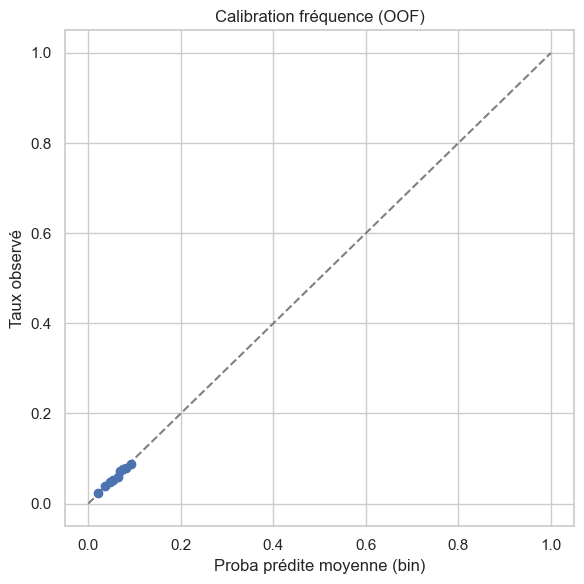

In [15]:
# Calibration fréquence (reliability-like)
cal_df = diag_tables.get("calibration_freq", pd.DataFrame()) if diag_tables else pd.DataFrame()
if not cal_df.empty:
    display(cal_df)
    plt.figure(figsize=(6, 6))
    plt.plot([0,1],[0,1], '--', color='gray')
    plt.plot(cal_df["p_mean"], cal_df["y_rate"], marker='o')
    plt.xlabel("Proba prédite moyenne (bin)")
    plt.ylabel("Taux observé")
    plt.title("Calibration fréquence (OOF)")
    plt.tight_layout()
else:
    print("Calibration table indisponible.")


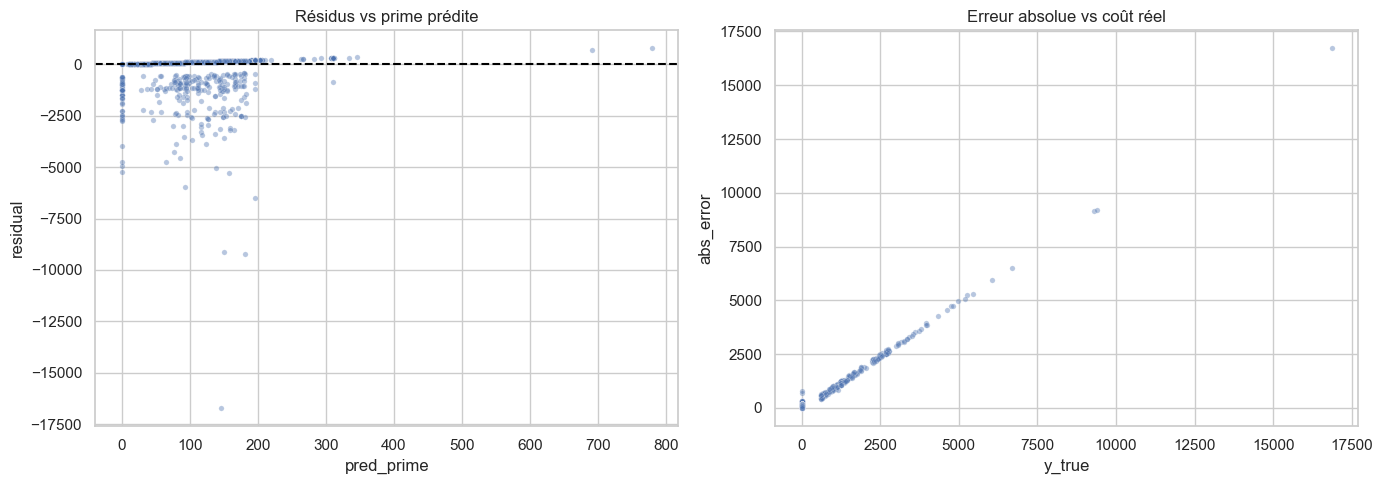

In [16]:
# Diagnostics résiduels prime
res_df = diag_tables.get("residuals", pd.DataFrame()) if diag_tables else pd.DataFrame()
if not res_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    sns.scatterplot(data=res_df.sample(min(len(res_df), 5000), random_state=SEED), x="pred_prime", y="residual", alpha=0.4, s=15, ax=axes[0])
    axes[0].axhline(0, ls="--", color="black")
    axes[0].set_title("Résidus vs prime prédite")
    sns.scatterplot(data=res_df.sample(min(len(res_df), 5000), random_state=SEED), x="y_true", y="abs_error", alpha=0.4, s=15, ax=axes[1])
    axes[1].set_title("Erreur absolue vs coût réel")
    plt.tight_layout()


In [17]:
# Error analysis par déciles (réel et prédit)
if diag_tables:
    err_true = diag_tables.get("error_by_decile_true", pd.DataFrame())
    err_pred = diag_tables.get("error_by_decile_pred", pd.DataFrame())
    if not err_true.empty:
        display(err_true)
    if not err_pred.empty:
        display(err_pred)


,decile_basis,bin,n,y_mean,pred_mean,bias,mae,rmse
0,y_true,"(-0.001, 21826.96]",50000,103.369344,81.973629,-21.395715,174.134052,545.929482


,decile_basis,bin,n,y_mean,pred_mean,bias,mae,rmse
0,y_pred,"(-0.001, 41.433]",15023,78.446182,9.303926,-69.142256,87.320850,472.411178
1,y_pred,"(118.576, 143.301]",5019,147.580996,130.958900,-16.622096,258.553494,666.301233
2,y_pred,"(143.301, 158.623]",5207,157.176614,150.664675,-6.511940,282.442556,673.700582
3,y_pred,"(158.623, 779.006]",4767,163.791647,179.792665,16.001018,312.056212,725.289979
4,y_pred,"(41.433, 68.63]",4985,59.729575,54.020339,-5.709236,109.704778,388.852144
5,y_pred,"(68.63, 84.733]",5001,70.454621,77.449763,6.995142,140.657518,379.715944
6,y_pred,"(84.733, 96.293]",5268,94.485822,92.199702,-2.286120,176.602465,576.689071
7,y_pred,"(96.293, 118.576]",4730,106.173569,109.454032,3.280463,202.601010,508.538081


In [19]:
# Error analysis segmentaire (merge OOF + features train si possible)
if run_id_main is not None and not oof_df.empty:
    train_raw, test_raw = load_project_datasets(DATA_DIR)

    d = oof_df[
        (oof_df["is_test"] == 0)
        & (oof_df["split"] == "primary_time")
        & (oof_df["run_id"].astype(str) == str(run_id_main))
    ].copy()

    d = d[["row_idx", "y_sev", "pred_prime"]].dropna()

    train_aug = v2.add_engineered_features(train_raw.copy()).reset_index(drop=True)

    merged = d.merge(
        train_aug.reset_index().rename(columns={"index": "row_idx"}),
        on="row_idx",
        how="left",
    )

    merged["abs_error"] = (merged["pred_prime"] - merged["y_sev"]).abs()
    merged["diff"] = merged["pred_prime"] - merged["y_sev"]  # <- biais = mean(diff)

    seg_cols = [c for c in ["utilisation","type_contrat","cp2","cp3","marque_vehicule","type_vehicule"] if c in merged.columns]
    seg_err_tables = {}

    for c in seg_cols:
        g = merged.groupby(c).agg(
            n=("y_sev", "size"),
            y_mean=("y_sev", "mean"),
            pred_mean=("pred_prime", "mean"),
            bias=("diff", "mean"),
            mae=("abs_error", "mean"),
        ).reset_index()

        seg_err_tables[c] = g[g["n"] >= 100].sort_values("mae", ascending=False)
        print(c)
        display(seg_err_tables[c].head(10))

utilisation


,utilisation,n,y_mean,pred_mean,bias,mae
1,Professional,3667,152.527289,87.174969,-65.352321,223.740716
3,WorkPrivate,32941,99.115298,82.139663,-16.975635,170.793636
2,Retired,13344,100.121001,80.077472,-20.043529,168.546514


type_contrat


,type_contrat,n,y_mean,pred_mean,bias,mae
0,Maxi,32360,138.036290,99.000836,-39.035454,221.425226
2,Median2,8759,44.162714,56.645431,12.482717,96.938711
1,Median1,4638,45.350220,48.296698,2.946478,90.583142
3,Mini,4243,24.618739,41.210694,16.591955,64.146004


cp2


,cp2,n,y_mean,pred_mean,bias,mae
93,93,747,169.460080,94.240729,-75.219351,245.072000
69,69,1185,145.459097,108.500857,-36.958240,236.184233
68,68,610,147.434525,98.312706,-49.121818,231.394645
30,30,506,140.148775,98.812699,-41.336076,225.432586
57,57,834,133.708058,104.852260,-28.855798,224.969896
58,58,188,156.931543,78.275313,-78.656230,223.369923
42,42,626,138.984984,92.342578,-46.642406,221.750830
94,94,1120,143.595973,92.275683,-51.320290,220.361126
77,77,908,143.819339,90.689564,-53.129776,218.887229
91,91,911,135.138825,97.198493,-37.940333,217.926974


cp3


,cp3,n,y_mean,pred_mean,bias,mae
355,683,100,314.047900,94.706677,-219.341223,396.447532
286,576,154,204.935519,131.897343,-73.038176,313.668621
267,543,185,229.824000,107.104145,-122.719855,312.112717
150,302,127,199.368189,99.765896,-99.602293,284.901936
468,916,166,179.695723,107.164116,-72.531606,273.723145
348,673,131,176.162901,108.467769,-67.695132,268.136447
334,644,221,169.504480,112.837870,-56.666609,267.173840
400,773,197,187.374619,97.869576,-89.505043,264.534871
406,782,116,162.992845,121.892005,-41.100840,262.632470
164,330,374,157.387781,117.381171,-40.006609,257.934802


marque_vehicule


,marque_vehicule,n,y_mean,pred_mean,bias,mae
87,VOLVO,268,188.244963,87.034409,-101.210553,253.560100
77,SUZUKI,399,154.405063,102.122315,-52.282748,241.487752
51,MERCEDES BENZ,1529,160.768672,90.639645,-70.129027,235.009611
16,CHEVROLET,151,143.361854,94.522496,-48.839359,227.460829
57,NISSAN,888,144.141982,97.725625,-46.416357,226.581724
17,CHRYSLER,105,156.009905,91.930108,-64.079797,224.382670
35,HYUNDAI,344,135.092703,103.066801,-32.025902,222.806952
32,HONDA,329,137.540152,99.001757,-38.538395,216.772011
14,BMW,758,133.643641,87.722091,-45.921551,206.252167
41,KIA,202,124.771782,94.506079,-30.265703,203.316965


type_vehicule


,type_vehicule,n,y_mean,pred_mean,bias,mae
1,Tourism,45036,107.644126,85.279264,-22.364862,181.133559
0,Commercial,4964,64.586287,51.983180,-12.603107,110.630870


In [20]:
# Extrêmes (top 1% coûts réels et grosses erreurs)
if diag_tables and "residuals" in diag_tables and len(diag_tables["residuals"]):
    res_df = diag_tables["residuals"].copy()
    q99_true = res_df["y_true"].quantile(0.99)
    extreme_true = res_df[res_df["y_true"] >= q99_true].sort_values("y_true", ascending=False).head(20)
    extreme_err = res_df.sort_values("abs_error", ascending=False).head(20)
    print("Top 1% coûts réels")
    display(extreme_true)
    print("Plus grosses erreurs absolues")
    display(extreme_err)


Top 1% coûts réels


,row_idx,y_true,y_freq,pred_freq,pred_sev,pred_prime,residual,abs_error,sq_error,is_extreme_true_top1
1923265,23265,21826.96,1.0,0.053848,1758.316205,94.682243,-21732.277757,21732.277757,4.722919e+08,1
1902408,2408,18246.90,1.0,0.064497,0.000000,0.000000,-18246.900000,18246.900000,3.329494e+08,1
1927721,27721,16859.40,1.0,0.079065,1842.270131,145.658868,-16713.741132,16713.741132,2.793491e+08,1
1912864,12864,15997.50,1.0,0.093048,1843.351791,171.520434,-15825.979566,15825.979566,2.504616e+08,1
1938429,38429,13813.54,1.0,0.048603,1840.500264,89.454482,-13724.085518,13724.085518,1.883505e+08,1
1924967,24967,12069.04,1.0,0.033027,1377.437436,45.491978,-12023.548022,12023.548022,1.445657e+08,1
1927492,27492,11906.24,1.0,0.068804,1758.316205,120.978754,-11785.261246,11785.261246,1.388924e+08,1
1927763,27763,11724.25,1.0,0.079065,2061.604824,163.000539,-11561.249461,11561.249461,1.336625e+08,1
1925981,25981,11509.30,1.0,0.077841,1935.638657,150.672443,-11358.627557,11358.627557,1.290184e+08,1
1931573,31573,11484.16,1.0,0.090628,1886.958511,171.011087,-11313.148913,11313.148913,1.279873e+08,1


Plus grosses erreurs absolues


,row_idx,y_true,y_freq,pred_freq,pred_sev,pred_prime,residual,abs_error,sq_error,is_extreme_true_top1
1923265,23265,21826.96,1.0,0.053848,1758.316205,94.682243,-21732.277757,21732.277757,4.722919e+08,1
1902408,2408,18246.90,1.0,0.064497,0.000000,0.000000,-18246.900000,18246.900000,3.329494e+08,1
1927721,27721,16859.40,1.0,0.079065,1842.270131,145.658868,-16713.741132,16713.741132,2.793491e+08,1
1912864,12864,15997.50,1.0,0.093048,1843.351791,171.520434,-15825.979566,15825.979566,2.504616e+08,1
1938429,38429,13813.54,1.0,0.048603,1840.500264,89.454482,-13724.085518,13724.085518,1.883505e+08,1
1924967,24967,12069.04,1.0,0.033027,1377.437436,45.491978,-12023.548022,12023.548022,1.445657e+08,1
1927492,27492,11906.24,1.0,0.068804,1758.316205,120.978754,-11785.261246,11785.261246,1.388924e+08,1
1927763,27763,11724.25,1.0,0.079065,2061.604824,163.000539,-11561.249461,11561.249461,1.336625e+08,1
1925981,25981,11509.30,1.0,0.077841,1935.638657,150.672443,-11358.627557,11358.627557,1.290184e+08,1
1931573,31573,11484.16,1.0,0.090628,1886.958511,171.011087,-11313.148913,11313.148913,1.279873e+08,1


In [21]:
# Feature importance fallback (sans SHAP) : permutation importance sur modèle proxy
try:
    from sklearn.ensemble import RandomForestRegressor
    train_raw, _ = load_project_datasets(DATA_DIR)
    bundles = v2.prepare_feature_sets(train_raw, test_raw if 'test_raw' in globals() else load_project_datasets(DATA_DIR)[1], rare_min_count=30, drop_identifiers=True)
    b = bundles["robust_v2"]
    X = b.X_train.copy()
    y = b.y_sev.to_numpy(dtype=float)
    n_fit = 6000 if QUICK_ANALYSIS else min(len(X), 20000)
    idx = np.random.RandomState(SEED).choice(len(X), size=n_fit, replace=False)
    Xs = X.iloc[idx].copy()
    ys = y[idx]
    num_cols = [c for c in Xs.columns if c in b.num_cols]
    cat_cols = [c for c in Xs.columns if c in b.cat_cols]
    Xmat, feat_names = _prepare_mixed_matrix(Xs, num_cols=num_cols, cat_cols=cat_cols)
    rf = RandomForestRegressor(n_estimators=80 if QUICK_ANALYSIS else 150, random_state=SEED, n_jobs=-1, max_depth=10)
    rf.fit(Xmat, ys)
    pi = permutation_importance(rf, Xmat, ys, n_repeats=3 if QUICK_ANALYSIS else 5, random_state=SEED, n_jobs=1)
    pi_df = pd.DataFrame({"feature": feat_names, "importance_mean": pi.importances_mean, "importance_std": pi.importances_std}).sort_values("importance_mean", ascending=False)
    display(pi_df.head(30))
except Exception as e:
    print("Permutation importance fallback indisponible:", type(e).__name__, e)


Permutation importance fallback indisponible: NameError name 'permutation_importance' is not defined


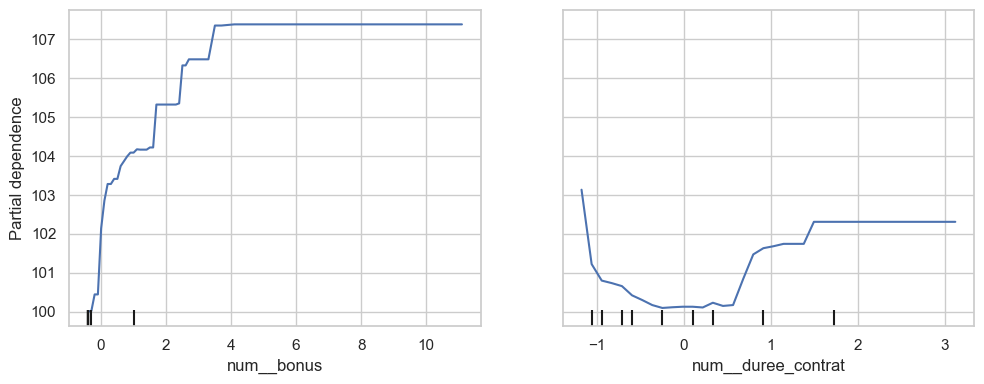

In [22]:
# PDP/ICE (optionnel, fallback safe)
try:
    from sklearn.inspection import PartialDependenceDisplay
    # Si la cellule précédente a créé rf/Xmat/feat_names
    if "rf" in globals() and "Xmat" in globals() and "feat_names" in globals():
        top_idx = list(np.argsort(-np.asarray(pi.importances_mean))[:2]) if "pi" in globals() else [0, 1]
        fig, ax = plt.subplots(figsize=(10,4))
        PartialDependenceDisplay.from_estimator(rf, Xmat, features=top_idx, feature_names=feat_names, ax=ax)
        plt.tight_layout()
    else:
        print("Modèle proxy indisponible.")
except Exception as e:
    print("PDP/ICE non disponible:", type(e).__name__, e)


## SHAP (section optionnelle)

- Si `shap` est installé: produire une analyse globale + locale sur un sous-échantillon.
- Sinon: conserver permutation importance + PDP/ICE comme fallback.

**Décision pratique**: dans ce repo, `shap` n'est pas une dépendance obligatoire.


In [23]:
# Stabilité des features importantes selon folds / seeds (proxy via runs V2 + catégories)
if not run_df.empty:
    cols = [c for c in ["engine","family","feature_set","seed","split","rmse_prime","q99_ratio_pos"] if c in run_df.columns]
    stability_view = run_df[cols].copy()
    summary = stability_view.groupby(["engine","family","feature_set","split"]).agg(
        n_runs=("rmse_prime","size"),
        rmse_mean=("rmse_prime","mean"),
        rmse_std=("rmse_prime","std"),
        q99_mean=("q99_ratio_pos","mean"),
    ).reset_index()
    display(summary.sort_values(["split","rmse_mean"]).head(30))


,engine,family,feature_set,split,n_runs,rmse_mean,rmse_std,q99_mean
6,catboost,two_part_tweedie,base_v2,aux_blocked5,4,542.588534,0.018556,0.291046
3,catboost,two_part_classic,base_v2,aux_blocked5,4,542.626976,0.056627,0.296188
24,xgboost,two_part_tweedie,base_v2,aux_blocked5,4,542.863905,0.025150,0.295572
21,xgboost,two_part_classic,base_v2,aux_blocked5,4,542.865231,0.020536,0.293026
0,catboost,direct_tweedie,base_v2,aux_blocked5,1,542.958342,NaN,0.333277
12,lightgbm,two_part_classic,base_v2,aux_blocked5,4,543.143219,0.125282,0.288097
15,lightgbm,two_part_tweedie,base_v2,aux_blocked5,4,543.145551,0.095934,0.287002
18,xgboost,direct_tweedie,base_v2,aux_blocked5,1,543.417720,NaN,0.314290
9,lightgbm,direct_tweedie,base_v2,aux_blocked5,1,543.817164,NaN,0.326298
7,catboost,two_part_tweedie,base_v2,primary_time,4,544.244949,0.336002,0.324925


In [24]:
# Shake-up public/private (standard + tail stratified)
for name in ["shakeup_v2_ensemble.parquet", "shakeup_v2_ensemble_tail.parquet", "shakeup_v2_single.parquet"]:
    p = ARTIFACT_V2 / name
    if p.exists():
        sh = pd.read_parquet(p)
        print(name, sh.shape)
        display(sh.describe())


shakeup_v2_ensemble.parquet (2000, 5)


,sim_id,rmse_public,rmse_private,gap_public_minus_private,stratified_tail
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.0
mean,999.500000,544.670142,546.046845,-1.376703,0.0
std,577.494589,23.992074,12.024106,36.008336,0.0
min,0.000000,470.048069,505.094513,-110.004223,0.0
25%,499.750000,528.181700,538.257306,-26.295018,0.0
50%,999.500000,544.246099,546.653655,-2.407556,0.0
75%,1499.250000,560.733316,554.476718,22.476010,0.0
max,1999.000000,619.371211,580.052293,114.276699,0.0


shakeup_v2_ensemble_tail.parquet (2000, 5)


,sim_id,rmse_public,rmse_private,gap_public_minus_private,stratified_tail
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.0
mean,999.500000,544.710052,545.767261,-1.057208,1.0
std,577.494589,37.661792,7.645607,45.297157,0.0
min,0.000000,436.125327,514.960229,-129.123901,1.0
25%,499.750000,518.143547,541.166254,-33.083900,1.0
50%,999.500000,541.750043,546.669135,-4.919092,1.0
75%,1499.250000,568.701492,551.227447,27.535238,1.0
max,1999.000000,679.553153,565.249228,164.592924,1.0


shakeup_v2_single.parquet (2000, 5)


,sim_id,rmse_public,rmse_private,gap_public_minus_private,stratified_tail
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.0
mean,999.500000,544.745310,546.125426,-1.380116,0.0
std,577.494589,23.981820,12.018969,35.992958,0.0
min,0.000000,470.139310,505.275723,-109.984960,0.0
25%,499.750000,528.235635,538.362119,-26.329367,0.0
50%,999.500000,544.348243,546.718409,-2.370166,0.0
75%,1499.250000,560.757492,554.565002,22.395373,0.0
max,1999.000000,619.279680,580.124270,114.003957,0.0


## Contrôles anti-fuite (checklist explicite)

- [ ] `index` / IDs exclus comme features brutes
- [ ] target encoding uniquement fit sur train fold (cross-fit)
- [ ] validation `GroupKFold(id_client)` pour anti-fuite client
- [ ] contrôle OOD train/test (nouvelles modalités, drift)
- [ ] garde-fous sur la queue de sévérité / collapse de distribution

**Décision pratique**: cette checklist doit être présentée explicitement en soutenance.


In [25]:
# Synthèse business (classes de risque, quantiles, segments)
train_raw, test_raw = load_project_datasets(DATA_DIR)
y = train_raw[v2.TARGET_SEV_COL].astype(float)
risk_class = pd.qcut(y.rank(method="first"), q=5, labels=["Q1","Q2","Q3","Q4","Q5"])
business_table = pd.DataFrame({"y": y, "risk_class": risk_class}).groupby("risk_class").agg(
    n=("y","size"),
    mean_cost=("y","mean"),
    median_cost=("y","median"),
    q95=("y", lambda s: float(np.quantile(s, 0.95))),
    q99=("y", lambda s: float(np.quantile(s, 0.99))),
).reset_index()
display(business_table)


,risk_class,n,mean_cost,median_cost,q95,q99
0,Q1,10000,0.00000,0.0,0.00,0.0000
1,Q2,10000,0.00000,0.0,0.00,0.0000
2,Q3,10000,0.00000,0.0,0.00,0.0000
3,Q4,10000,0.00000,0.0,0.00,0.0000
4,Q5,10000,516.84672,0.0,2683.76,4949.4405


## Limites & risques (à compléter)

- `Constat`: score public != score privé (seulement 1/3 public)
- `Interprétation`: sélection opportuniste sur public très risquée
- `Décision`: piloter les soumissions par robustesse locale (multi-splits + shake-up)

Limites typiques à mentionner:
- OOD catégoriel
- queue lourde / événements rares
- bruit cible et variables proxy imparfaites


## Décisions finales de modélisation (à synthétiser)

À remplir explicitement:
- Pourquoi **fréquence + sévérité** et pas seulement un modèle direct
- Pourquoi ces **splits** de CV
- Pourquoi `log1p` / Tweedie / tail mapping safe
- Pourquoi single model vs ensemble (selon stabilité)


In [26]:
# Exports diagnostics notebook 3 + storytelling summary
if diag_tables:
    export_tables = {}
    for k, v in diag_tables.items():
        if isinstance(v, pd.DataFrame):
            export_tables[f"oof_model_diagnostics_{k}"] = v
    if export_tables:
        export_analysis_tables(export_tables, ARTIFACT_DS)

storytelling_md = ARTIFACT_DS / "storytelling_summary.md"
storytelling_md.write_text(
    "\n".join(
        [
            "# Storytelling summary (draft)",
            "",
            "## 1) Problème métier",
            "- Tarifer une prime juste et robuste.",
            "",
            "## 2) Démarche data science",
            "- Cadrage métier -> qualité -> EDA -> FE -> CV -> diagnostics -> robustesse.",
            "",
            "## 3) Choix techniques justifiés",
            "- Two-part model (fréquence × sévérité)",
            "- Multi-splits anti-fuite",
            "- Garde-fous de queue et de distribution",
            "",
            "## 4) Points de vigilance",
            "- OOD catégoriel et événements extrêmes",
            "- Risque de shake-up public/privé",
            "",
        ]
    ),
    encoding="utf-8"
)
print("Exports DS notebook 3 ->", ARTIFACT_DS)
print("Storytelling summary:", storytelling_md)


Exports DS notebook 3 -> c:\Users\icemo\Downloads\Calcul-prime-d-assurance\artifacts\ds
Storytelling summary: c:\Users\icemo\Downloads\Calcul-prime-d-assurance\artifacts\ds\storytelling_summary.md


## Conclusion soutenance (10 points à dire oralement)

1. Le problème est un problème de **tarification** avec coût d'erreur asymétrique (RMSE pertinent).
2. La décomposition **fréquence × sévérité** est standard actuarielle et explicable.
3. La sévérité présente une **queue lourde**, donc les choix de transformation et de robustesse sont centraux.
4. Le dataset montre du **drift/OOD** sur certaines catégories fines.
5. Le split `GroupKFold(id_client)` est indispensable pour éviter la fuite client.
6. Les scores sont pilotés par **OOF multi-splits**, pas par un seul score public Kaggle.
7. La calibration fréquence compte car la prime finale multiplie probabilité × montant.
8. L'analyse d'erreurs par segments et déciles révèle où le modèle sous-/sur-tarife.
9. Les contrôles anti-fuite et anti-collapse de distribution sont intégrés à la démarche.
10. La stratégie de soumission privilégie la **robustesse privée** plutôt que l'optimisation opportuniste du public.
